In [ ]:
!pip uninstall -y tensorflow
!pip uninstall -y keras
!pip install tensorflow==1.13.1
!pip install keras==2.1.0
!pip install h5py==2.10.0
!pip install -r requirements.txt
!python setup.py install
%tensorflow_version 1.x

Found existing installation: tensorflow 1.13.1
Uninstalling tensorflow-1.13.1:
  Successfully uninstalled tensorflow-1.13.1
Found existing installation: Keras 2.1.0
Uninstalling Keras-2.1.0:
  Successfully uninstalled Keras-2.1.0
  Using cached tensorflow-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (92.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires tensorflow>=2.0.0, but you have tensorflow 1.13.1 which is incompatible.
  Using cached Keras-2.1.0-py2.py3-none-any.whl (302 kB)
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
python3: can't open file 'setup.py': [Errno 2] No such file or directory
TensorFlow 1.x selected.


In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw

ROOT_DIR = ROOT_DIR = "/content/drive/MyDrive/MCNN/Segmentation"
assert os.path.exists(ROOT_DIR), 

sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [ ]:
class OrganConfig(Config):
    NAME = "organ"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 2  # background + lung +  heart

    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    STEPS_PER_EPOCH = 50

    VALIDATION_STEPS = 5
    
    BACKBONE = 'resnet50'

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = OrganConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        self.add_class("object", 1, "lung")
        self.add_class("object", 2, "heart")

        assert subset in ["train_test", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations1 = json.load(open('/content/drive/MyDrive/MCNN/Segmentation/Dataset/train_test/via_project_18Jul2021_12h48m_json.json'))

        annotations = list(annotations1.values()) 

        annotations = [a for a in annotations if a['regions']]
        
        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"lung": 1,"heart": 2}
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object", 
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)


        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids 

In [ ]:
dataset_train = CustomDataset()
dataset_train.load_custom("/content/drive/MyDrive/MCNN/Segmentation/Dataset", "train_test")
dataset_train.prepare()

dataset_val = CustomDataset()
dataset_val.load_custom("/content/drive/MyDrive/MCNN/Segmentation/Dataset", "val")
dataset_val.prepare()

objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['lung', 'lung', 'heart']
numids [1, 1, 2]
objects: ['l

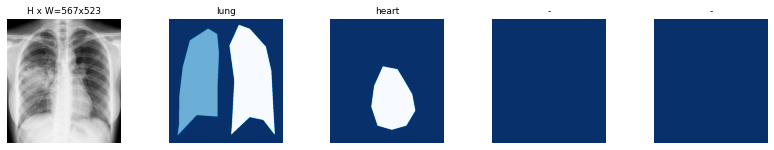

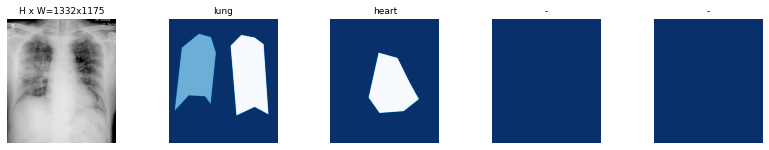

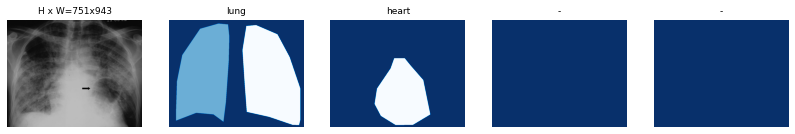

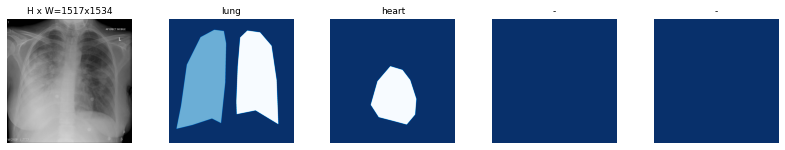

In [ ]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
init_with = "coco"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/MCNN/Segmentation/logs/organ20210725T2156/mask_rcnn_organ_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/4
50/50 [==============================] - 39s 775ms/step - loss: 2.1612 - val_loss: 1.2873

Epoch 2/4
50/50 [==============================] - 6s 112ms/step - loss: 1.1546 - val_loss: 1.1964
Epoch 3/4
50/50 [==============================] - 6s 115ms/step - loss: 0.9117 - val_loss: 0.5439
Epoch 4/4
50/50 [==============================] - 13s 258ms/step - loss: 0.7808 - val_loss: 0.5575
Training took 2.6 minutes


In [ ]:
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=8, 
            layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 4. LR=0.0001

Checkpoint Path: /content/drive/MyDrive/MCNN/Segmentation/logs/organ20210725T2156/mask_rcnn_organ_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers ma

Epoch 5/8
50/50 [==============================] - 38s 766ms/step - loss: 0.6554 - val_loss: 0.4425
Epoch 6/8
50/50 [==============================] - 9s 183ms/step - loss: 0.6005 - val_loss: 0.6476
Epoch 7/8
50/50 [==============================] - 9s 171ms/step - loss: 0.5822 - val_loss: 0.6946
Epoch 8/8
50/50 [==============================] - 17s 350ms/step - loss: 0.5549 - val_loss: 0.3315
Training took 3.34 minutes


In [ ]:
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)



Instructions for updating:
Use `tf.cast` instead.


In [ ]:
model_path = model.find_last()
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/MCNN/Segmentation/logs/organ20210725T2156/mask_rcnn_organ_0008.h5
Re-starting from epoch 8


Processing 1 images
image                    shape: (402, 445, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  445.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


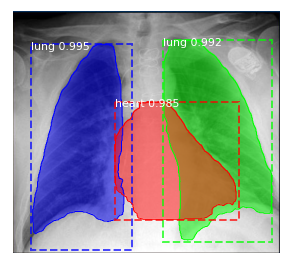

Processing 1 images
image                    shape: (401, 443, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  443.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


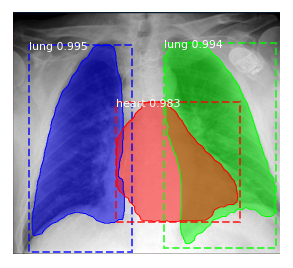

Processing 1 images
image                    shape: (631, 790, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  790.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


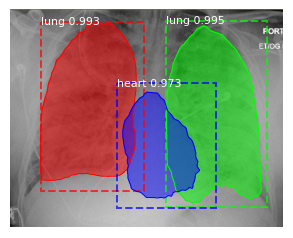

Processing 1 images
image                    shape: (1094, 1169, 3)       min:    8.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1169.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


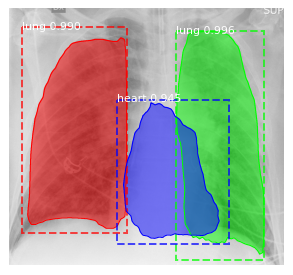

Processing 1 images
image                    shape: (1648, 2150, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 2150.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


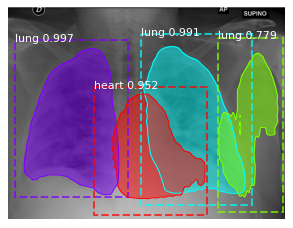

In [ ]:
import skimage
real_test_dir = '/content/drive/MyDrive/MCNN/Segmentation/Dataset/val'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths[0:5]:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))